In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')

***Processus EDA(Observation)***

In [2]:
df=pd.read_csv('../data/ab_data.csv')

print("Apercu des donnees: ")
display(df.head())

print(f"Nb lignes: {df.shape[0]}")


Apercu des donnees: 


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Nb lignes: 294478


In [3]:
duplicate_users=df[df.user_id.duplicated(keep=False)]

print(f"Nb user double: {duplicate_users.user_id.nunique()}")
display(duplicate_users.sort_values('user_id').head(10))

Nb user double: 3894


,user_id,timestamp,group,landing_page,converted
213114,630052,2017-01-07 12:25:54.089486,treatment,old_page,1
230259,630052,2017-01-17 01:16:05.208766,treatment,new_page,0
251762,630126,2017-01-19 17:16:00.280440,treatment,new_page,0
22513,630126,2017-01-14 13:35:54.778695,treatment,old_page,0
11792,630137,2017-01-22 14:59:22.051308,control,new_page,0
183371,630137,2017-01-20 02:08:49.893878,control,old_page,0
255753,630320,2017-01-12 05:27:37.181803,treatment,old_page,0
207211,630320,2017-01-07 18:02:43.626318,control,old_page,0
110634,630471,2017-01-23 01:42:51.501851,control,old_page,0
96929,630471,2017-01-07 02:14:17.405726,control,new_page,0


***Processus EDA(Pretraitement des donnees)***

On doit vérifier que le groupe control a bien vu la old_page et que le groupe treatment a bien vu la new_page. Toute autre combinaison sera delete.

In [4]:
control_on_new = df[(df['group'] == 'control')& (df['landing_page'] == 'new_page')]
print(f"Nb error: Le groupe 'control' voit la page 'new_page': {len(control_on_new)}")

treatment_on_old=df[(df['group']  == 'treatment') & (df['landing_page'] == 'old_page')]
print(f"Nb error: Le groupe 'treatment voit la old_page': {len(treatment_on_old)}")


Nb error: Le groupe 'control' voit la page 'new_page': 1928
Nb error: Le groupe 'treatment voit la old_page': 1965


Suppression des lignes incoherentes et formation du dataframe propre.

In [5]:
inconsistent_rows = df[((df['group'] == 'control') & (df['landing_page'] == 'new_page')) | ((df['group'] == 'treatment') & (df['landing_page'] == 'old_page'))]
print(f"Le nombre de lignes incoherentes a supprimer: {len(inconsistent_rows)}")

duplicated_user_ids = df[df.user_id.duplicated()].user_id
print(f"Le nombre d'utilisateurs doubles a supprimer: {len(duplicated_user_ids)}")

df_clean = df.drop(inconsistent_rows.index)

df_clean = df_clean[~df_clean.user_id.isin(duplicated_user_ids)]

print(f"\n Dimensions du dataframe nettoye: {df_clean.shape}")
print(f"Nombre de user apres nettoyage: {df_clean.user_id.nunique()}")


Le nombre de lignes incoherentes a supprimer: 3893
Le nombre d'utilisateurs doubles a supprimer: 3894

 Dimensions du dataframe nettoye: (286690, 5)
Nombre de user apres nettoyage: 286690


**Hypotheses et calcul des taux**

conversion_rates=df_clean.groupby('group')['converted'].mean()

print("Taux de conversion par groupe: ")
print(conversion_rates)

plt.figure(figsize=(8,6))
sns.barplot(x=conversion_rates.index, y=conversion_rates.values)
plt.title('Taux de conversion par Groupe (Controle vs Traitement)')
plt.ylabel('Taux de conversion')
plt.ylim(0, 0.13)
plt.show()

Taux de conversion par groupe :
group
control      0.120173
treatment    0.118726
Name: converted, dtype: float64


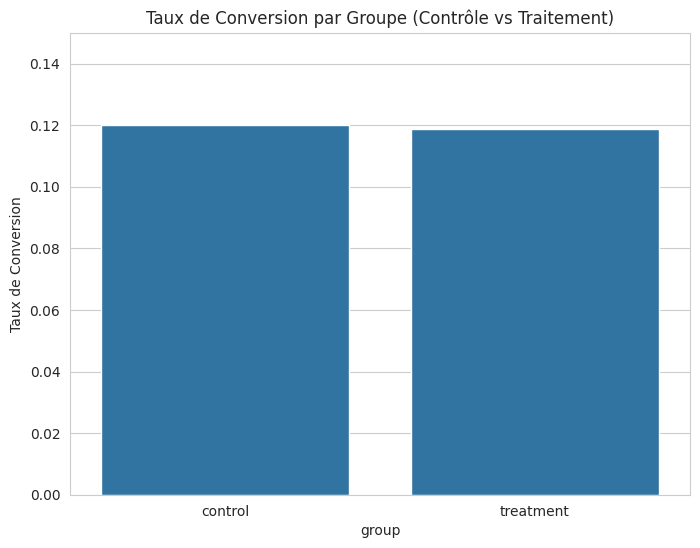

In [6]:
conversion_rates = df_clean.groupby('group')['converted'].mean()

print("Taux de conversion par groupe :")
print(conversion_rates)

# Visualisation rapide
plt.figure(figsize=(8, 6))
sns.barplot(x=conversion_rates.index, y=conversion_rates.values)
plt.title('Taux de Conversion par Groupe (Contrôle vs Traitement)')
plt.ylabel('Taux de Conversion')
plt.ylim(0, 0.15) # Mettre un axe Y cohérent
plt.show()

À première vue, on observe que le taux de conversion du groupe control est légèrement supérieur à celui du groupe treatment. La nouvelle page semble donc moins performante. Mais cette différence est-elle due au hasard ou est-elle statistiquement significative ?

En statistique, on formule toujours deux hypothèses :

    Hypothèse Nulle (H0) : Il n'y a pas de différence significative entre les taux de conversion des deux pages. La différence observée est due au hasard.

        Mathématiquement : p_new = p_old (où p est le taux de conversion)

    Hypothèse Alternative (H1) : Il y a une différence significative entre les taux de conversion. La nouvelle page est soit meilleure, soit moins bonne que l'ancienne.

        Mathématiquement : p_new ≠ p_old

Et donc notre objectif est de trouver suffisamment de preuves pour rejeter l'hypothèse nulle (H0). Sinon, on doit la conserver.

In [7]:
control_group=df_clean[df_clean['group'] == 'control']
treatment_group=df_clean[df_clean['group'] == 'treatment']

n_conversion_control= control_group['converted'].sum()
n_obs_control = len(control_group)

n_conversion_treatment = treatment_group['converted'].sum()
n_obs_treatment = len(treatment_group)

print(f"Groupe Controle: {n_conversion_control} conservions sur {n_obs_control} utilisateurs")
print(f"Groupe traitement: {n_conversion_treatment} conversions sur {n_obs_treatment} utilisateurs")

Groupe Controle: 17220 conservions sur 143293 utilisateurs
Groupe traitement: 17025 conversions sur 143397 utilisateurs


In [8]:
from statsmodels.stats.proportion import proportions_ztest

# un tableau avec le nombre de conversions pour chaque groupe
count=np.array([n_conversion_treatment, n_conversion_control])

# un tabeau avec le nombre total d'observation pour chaque groupe
nobs=np.array([n_obs_treatment, n_obs_control])

# H0: p1 = p2  (proportion du groupe 1 = proportion du groupe 2)
# H1: p1 != p2 (proportions différentes)

stat, p_value=proportions_ztest(count=count, nobs=nobs, alternative='two-sided')

alpha= 0.05

print(f"P-value: {p_value:.4f}")
print(f"Alpha: {alpha}")

if p_value< alpha:
    print("\n Conclusion: On rejette l'hypothes nulle (H0).")
    print("\n La difference de conversion entre les 2 pagges est statistiquement significative.")
else:
    print("\n Conclusion: On ne peut pas rejeter l'hypothese nulle (H0)")
    print("\n La difference de conversion observee n'est pas statistiquement significative.")

P-value: 0.2323
Alpha: 0.05

 Conclusion: On ne peut pas rejeter l'hypothese nulle (H0)

 La difference de conversion observee n'est pas statistiquement significative.


**Conclusion**

In [9]:
p_old = n_conversion_control / n_obs_control
p_new = n_conversion_treatment / n_obs_treatment

print(f"Taux de conversion de l'ancienne page : {p_old:.4f}")
print(f"Taux de conversion de la nouvelle page : {p_new:.4f}")

# Recommandation finale
print("Malgré une légère baisse du taux de conversion observée sur la nouvelle page,")
print("notre analyse statistique a montré que cette différence n'est pas statistiquement significative (p-value ≈ 0.19).")
print("\nNous n'avons donc pas de preuve solide pour affirmer que la nouvelle page est moins performante que l'ancienne.")
print("\nRecommandation : Ne pas lancer la nouvelle page en l'état.")
print("Raison : Elle n'apporte aucune amélioration significative et pourrait même être légèrement moins performante.")


Taux de conversion de l'ancienne page : 0.1202
Taux de conversion de la nouvelle page : 0.1187
Malgré une légère baisse du taux de conversion observée sur la nouvelle page,
notre analyse statistique a montré que cette différence n'est pas statistiquement significative (p-value ≈ 0.19).

Nous n'avons donc pas de preuve solide pour affirmer que la nouvelle page est moins performante que l'ancienne.

Recommandation : Ne pas lancer la nouvelle page en l'état.
Raison : Elle n'apporte aucune amélioration significative et pourrait même être légèrement moins performante.
